In [1]:
import bnlearn as bn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pyAgrum as gum
import pyAgrum.causal as csl
import pyAgrum.lib.image as gumimage
import os
import seaborn as sns
os.chdir('../')
from GraphSurgery import GraphSurgeryClassifier
from id4ip import ID4IP
from utils import *
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from GraphModel import * 
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
import matplotlib
sns.set_theme(style='ticks', font_scale= 1.8)
font = {'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
os.chdir('sachs_experiment')
import func_timeout

In [2]:
bif_file = "alarm.bif"
target = 'BP'
chS = "VENTTUBE"
alarm_bn = gum.fastBN('HISTORY[2];'
                     'LVEDVOLUME[3] -> PCWP[3];'
                     'LVEDVOLUME->CVP[3];'
                     'STROKEVOLUME[3]->CO[3]->BP[3];'
                     'HR[3]->CO; HR->HRBP[3] ;'
                    'ERRLOWOUTPUT[2]->HRBP;'
                    'HR->HRSAT[3];'
                    'HR->HREKG[3];'
                    'CATECHOL[2]->HR;'
                    'TPR[3]->BP; TPR->CATECHOL;'
                    'ANAPHYLAXIS[2]->TPR;'
                    'INSUFFANESTH[2]->CATECHOL;'
                    'SAO2[3]->CATECHOL;'
                    'ARTCO2[3]->CATECHOL;'
                    'ARTCO2->EXPCO2[4];'
                    'PVSAT[3]->SAO2;'
                    'SHUNT[2]->SAO2;'
                    'PAP[3];'
                    'FIO2[2]->PVSAT;'
                    'MINVOL[4];'
                    'VENTLUNG[4]->VENTALV[4]->PVSAT;'
                    'VENTLUNG->EXPCO2;'
                    'VENTLUNG->MINVOL;'
                    'MINVOLSET[3]->VENTTUBE[4]->PRESS[4];'
                    'HISTORY<-U1[2]->LVEDVOLUME;'
                    'LVEDVOLUME<-U2[2]->STROKEVOLUME;'
                    'HRSAT<-U3[2]->HREKG;'
                    'PAP<-U4[2]->SHUNT;'
                    'SHUNT<-U5[3]->MINVOL;'
                    'MINVOL<-U6[3]->VENTALV;'
                    'VENTALV<-U7[3]->PRESS;'
                    'VENTALV<-U8[3]->PRESS;'
                    )
3

num_nodes = len(list(alarm_bn.nodes()))   #number of nodes excluding S

# TO-do here TOMORROW
latent_spec=[('U1', ('HISTORY', 'LVEDVOLUME')),
             ('U2', ('LVEDVOLUME', 'STROKEVOLUME')),
             ('U3', ('HRSAT', 'HREKG')),
             ('U4', ('PAP', 'SHUNT')),
             ('U5', ('SHUNT', 'MINVOL')),
             ('U6', ('MINVOL', 'VENTALV')),
             ('U7', ('VENTALV', 'PRESS')),
             ('U8', ('PRESS', 'VENTLUNG')),
             ]

b_edges=[('HISTORY', 'LVEDVOLUME'),('LVEDVOLUME', 'STROKEVOLUME'), ('HRSAT', 'HREKG'), ('PAP', 'SHUNT'), ('SHUNT', 'MINVOL'), ('MINVOL', 'VENTALV'), ('VENTALV', 'PRESS'), ('PRESS', 'VENTLUNG')]   #bi-directed edges

latent_conf = {'HISTORY':['U1'],  
               'LVEDVOLUME':['U1','U2'], 
               'PCWP':[], 
               'CVP':[], 
               'STROKEVOLUME':['U2'], 
               'CO':[],
               'BP':[],
               'HR':[],
               'HRBP':[],
               'ERRLOWOUTPUT':[],
               'HRSAT':['U3'],
               'HREKG':['U3'],
               'CATECHOL':[],
               'TPR':[],
               'ANAPHYLAXIS':[],
               'INSUFFANESTH':[],
               'SAO2':[],
               'ARTCO2':[],
               'EXPCO2':[],
               'PVSAT':[],
               'SHUNT':['U4', 'U5'],
               'PAP':['U4'],
               'FIO2':[],
               'MINVOL':['U5', 'U6'],
               'VENTLUNG':['U8'],
               'VENTALV':['U6', 'U7'],
               'MINVOLSET':[],
               'VENTTUBE':[],
               'PRESS':['U7','U8']
               }

conf_children = {}
for i in latent_spec:
    latent_name, tup = i
    conf_children[latent_name] = [tup[0], tup[1]]

confounded_edges=[(alarm_bn.idFromName(e[0]), alarm_bn.idFromName(e[1])) for e in b_edges]
num_latent = len(confounded_edges)

In [4]:
conf_children

{'U1': ['HISTORY', 'LVEDVOLUME'],
 'U2': ['LVEDVOLUME', 'STROKEVOLUME'],
 'U3': ['HRSAT', 'HREKG'],
 'U4': ['PAP', 'SHUNT'],
 'U5': ['SHUNT', 'MINVOL'],
 'U6': ['MINVOL', 'VENTALV'],
 'U7': ['VENTALV', 'PRESS'],
 'U8': ['PRESS', 'VENTLUNG']}

In [5]:
import os
os.chdir('/Users/lee4094/Github/invariant-prediction/alarm_experiment')

[bnlearn] >Import <alarm.bif>
[bnlearn] >Loading bif file <alarm.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [BP] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HREKG] does not add up to 1 but is: [[0.9999999 0.9999999 1.       ]
 [0.9999999 1.        1.       ]]
[bnlearn] >CPD [HRSAT] does not add up to 1 but is: [[0.9999999 0.9999999 1.       ]
 [0.9999999 1.        1.       ]]
[bnlearn] >CPD [PRESS] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >Check whether CPDs associated with the nodes are consistent: True
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


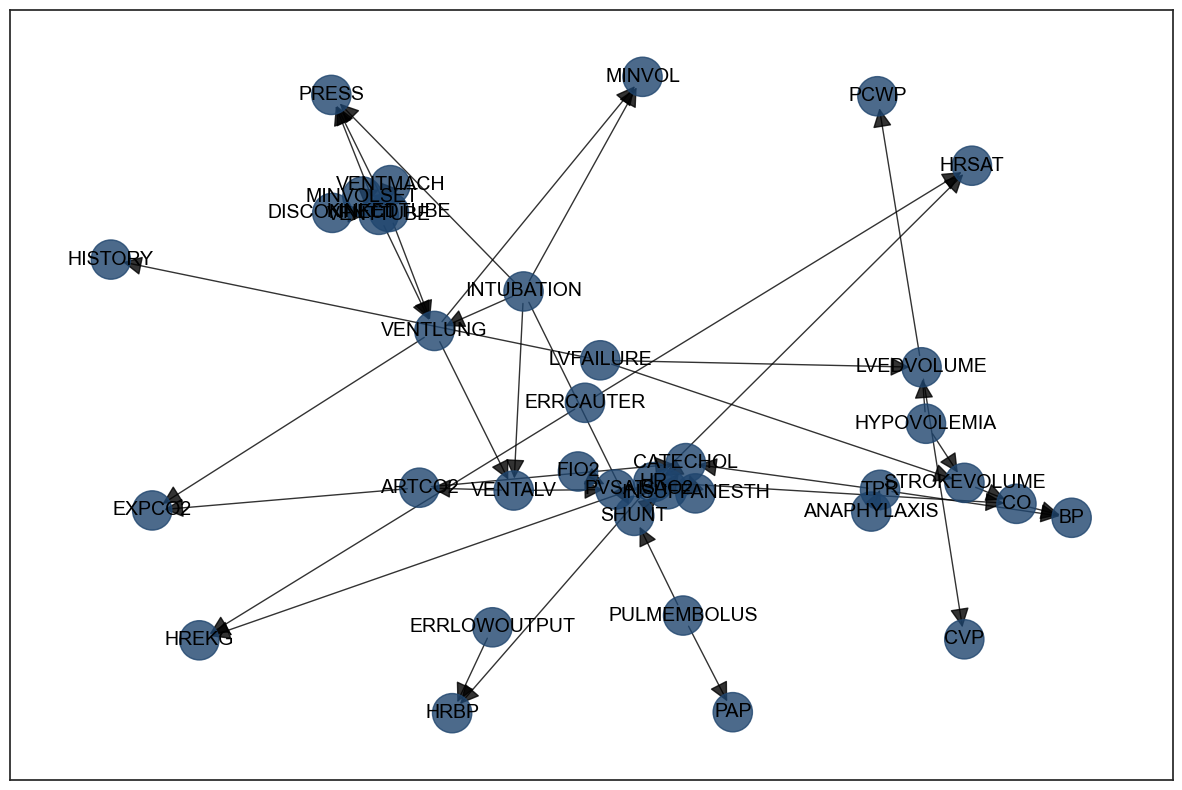

In [6]:
# loading data from bin file and preprocessing
model = bn.import_DAG(bif_file)
G = bn.plot(model)
df_dataset = bn.sampling(model, n=15000)  #returns a pandas datafram

In [7]:
df_dataset.columns

Index(['LVFAILURE', 'HISTORY', 'LVEDVOLUME', 'CVP', 'PCWP', 'HYPOVOLEMIA',
       'STROKEVOLUME', 'ERRLOWOUTPUT', 'HRBP', 'HR', 'ERRCAUTER', 'HREKG',
       'HRSAT', 'ANAPHYLAXIS', 'TPR', 'ARTCO2', 'EXPCO2', 'VENTLUNG',
       'INTUBATION', 'MINVOL', 'FIO2', 'PVSAT', 'VENTALV', 'SAO2', 'SHUNT',
       'PULMEMBOLUS', 'PAP', 'PRESS', 'KINKEDTUBE', 'VENTTUBE', 'MINVOLSET',
       'VENTMACH', 'DISCONNECT', 'CATECHOL', 'INSUFFANESTH', 'CO', 'BP'],
      dtype='object')

In [8]:
latent_spec=[('U1', ('HISTORY', 'LVEDVOLUME')),
             ('U2', ('LVEDVOLUME', 'STROKEVOLUME')),
             ('U3', ('HRSAT', 'HREKG')),
             ('U4', ('PAP', 'SHUNT')),
             ('U5', ('SHUNT', 'MINVOL')),
             ('U6', ('MINVOL', 'VENTALV')),
             ('U7', ('VENTALV', 'PRESS')),
             ('U8', ('PRESS', 'VENTLUNG')),
             ]

In [9]:
# drop pkc
drop = ['LVFAILURE', 'HYPOVOLEMIA', 'ERRCAUTER', 'PULMEMBOLUS', 'INTUBATION']
selected_col = [i for i in df_dataset.columns if i not in drop]


dis_0= df_dataset[df_dataset['DISCONNECT']==0]
dis_0 = dis_0[selected_col]
path = "tr_data_graph.csv"
dis_0.to_csv(path, index=False)

dis_1= df_dataset[df_dataset['DISCONNECT']==1]
dis_1 = dis_1[selected_col]
path = "te_data_graph.csv"
dis_1.to_csv(path, index=False)


In [10]:
dis_1.shape

(13538, 32)

In [11]:
dis_0.shape

(1462, 32)

In [12]:
Y_col = [target]
X_col = [i for i in selected_col if i not in Y_col]

# ready the training data with respect to ith graph
df = pd.read_csv("tr_data_graph.csv")
X_train = df[X_col]  # get the features
y_train = df[Y_col]  # get the target
# Add the data to csv files
X_train, X_validate, y_train, y_validate =  train_test_split(X_train, y_train, test_size=0.3)
X_train_copy = X_train.copy()
X_train_copy[target] = y_train
X_train_copy.to_csv("splitted_tr_data_graph.csv")


X_validate.to_csv("X_validate_data.csv")
y_train.to_csv("y_train.csv", index = False)

df_test = pd.read_csv("te_data_graph.csv")
X_test  = df_test[X_col] # get the features
y_test = df_test[Y_col] # get the target
X_test.to_csv("X_test.csv", index = False)
y_test.to_csv("y_test.csv", index = False)

lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
y_train_binarized = lb.transform(y_train)
y_test_binarized = lb.transform(y_test)
y_validate_binarized = lb.transform(y_validate)




In [14]:
g = GraphModel()
g.bn_with_latent_as_observed_without_S = alarm_bn
g.latent_spec = latent_spec
g.conf_child = conf_children
g.latent_conf = latent_conf 
g.bn_without_latent = g.removeLatent(alarm_bn, conf_children)
g.target = target

# construct the bn without u by changing every bidirected edge to directed edge 
g.create_bn_without_latent()

# learn the cpt
g.learnCPT("splitted_tr_data_graph.csv")

# Add a selection variable
g.chS = [chS]
g.s_name_list = ["S"]
bn_with_S = gum.BayesNet(g.bn_without_latent)
bn_with_S.add("S", 2)
bn_with_S.addArc("S", chS)
g.bn_with_S_and_without_latent = bn_with_S

if g.added_edges_tuple:
    g.remove_added_directed_edges_from_bn_without_latent()

# convert bn to causal models
g.convertBayesNetToCausalModel()

# STEP 8: output the graphs for reference
gumimage.export(g.cm_with_S, "sachs_causal_graph.png")

In [18]:
from sklearn.metrics import f1_score

# fit all estimators with training data
time_restriction = 120
id4ip = ID4IP(g)
id4ip.fit(X_validate, y_validate, zero_one_loss, time_restriction)
id4ip_res = id4ip.predict(X_test)
id4ip_score = f1_score(y_test[target].tolist(), id4ip_res[target].tolist(), average='micro')
print("ID4IP:{}".format(id4ip_score ))

gse = GraphSurgeryClassifier(g)
gse.fit(X_validate, y_validate, zero_one_loss, time_restriction)
gse_res = gse.predict(X_test)
gse_score = f1_score(y_test[target].tolist(), gse_res[target].tolist(), average='micro')
print("GSE:{}".format(gse_score))

# skilled model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train[["HISTORY", 'LVEDVOLUME', 'STROKEVOLUME', 'CVP', 'PCWP']], y_train)
logit_pred = model.predict(X_test[["HISTORY", 'LVEDVOLUME', 'STROKEVOLUME', 'CVP', 'PCWP']])
logit_score = f1_score(y_test, logit_pred, average='micro')
print("Logistic regression:")
print(logit_score)



Updated!
Intervention_set:['TPR', 'CO']
Conditioning_set:[]
Training Loss:0.214123006833713
final query:P(BP|do(['TPR', 'CO']), [])
ID4IP's corresponding training loss: 0.214123006833713
ID4IP:0.8255281430048752
Updated!
Intervention_set:['VENTTUBE']
Conditioning_set:[]
Training Loss:1.8542141230068336
Updated!
Intervention_set:['VENTTUBE']
Conditioning_set:['SAO2']
Training Loss:1.744874715261959
Updated!
Intervention_set:['VENTTUBE']
Conditioning_set:['CO']
Training Loss:1.1571753986332574
GSE:0.5677352637021716
Logistic regression:
0.5235633032944305
